# **Проект "Рыночная стоимость авто"**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

# **1. Вводная информация**

## **1.1. Задача**

Нам нужно построить модель для определения стоимости авто. 

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## **1.2. Описание набора данных**

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

## **1.3. План работы**

Коротко опишем наш пайплайн работы:

1. Загрузим и познакомимся с данными, оценим их качество и состояние;
2. Выполним необходимую предобработу данных;
3. Определим явные и скрытые взаимосвязи;
4. Определим признаки, которые лучше всего подходят для обучения;
5. Определим сетку параметров для поиска наиболее удачной модели;
6. Предварительное обучение и подбор параметров произведем для начала на небольшом количестве данных;
7. Проверим два основных варианта модели линейной регрессии и градиентного бустинга (LightGBM).
8. Проанализируем и сравним характеристики моделей: точность предсказания, скорость работы и качество моделей.

Выбранная метрика для оценки качества: `RMSE`.


# **2. Настройка рабочего пространства**

In [2]:
!pip install wordcloud
!pip install Pillow

## **2.1. Импорт библиотек и настройка рабочего пространства.**

In [3]:
from IPython.display import display, HTML 
import warnings

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Any, Callable, Dict, Optional, Union

from phik import phik_matrix

import lightgbm as lgb
from sklearn.linear_model import Ridge

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans

from wordcloud import WordCloud

In [4]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
# %matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.3f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

## **2.2. Загрузка данных**

In [5]:
try:
    df = pd.read_csv('datasets/autos.csv')
    print("Данные загружены с домашнего компьютера")
except (FileNotFoundError, OSError):
    # Альтернативный путь для запуска из Интернета
    df = pd.read_csv('/datasets/autos.csv')
    print("Данные загружены из Интернета")

Данные загружены с домашнего компьютера


## **2.3. Переименуем столбцы**

In [6]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower().replace(' ', '_').replace('-', '_') for col in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

## **2.4. Сокращение размерности**

Для ускорения предварительной обработки и обучения сократим датасет

In [7]:
# df = df[:100_000]

## **2.5. Деление данных на выборки**

In [8]:
# Разделение всего датафрейма
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Train/Val split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

total = len(df)

print(f'Train: {train_df.shape[0]:>6} строк ({train_df.shape[0]/total*100:>5.1f}%)')
print(f'Valid: {val_df.shape[0]:>6} строк ({val_df.shape[0]/total*100:>5.1f}%)')
print(f'Test:  {test_df.shape[0]:>6} строк ({test_df.shape[0]/total*100:>5.1f}%)')

Train: 212620 строк ( 60.0%)
Valid:  53156 строк ( 15.0%)
Test:   88593 строк ( 25.0%)


Для удобства итераций и предобработки создадим словарь датафреймов.

In [9]:
df_dict = {
            'train_df': train_df, 
            'test_df': test_df, 
            'val_df': val_df
            }

# **3. EDA: исследовательский анализ данных**

# **3.1. Оценка качества представленных данных**

In [10]:
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [11]:
df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [12]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


## **3.2. Вывод о качестве данных**

**Качество данных УДОВЛЕТВОРИТЕЛЬНОЕ с серьезными проблемами**

**1. Аномальные значения и подозрительные значения:**

`Price`:  min=0, max=20000 (цена 0€ — явная ошибка)

`Power`: min=0, max=20000 (мощность 0 и 20000 л.с. — нереально)

`RegistrationYear`: min=1000, max=9999 (автомобили из 1000 и 9999 года — ошибка), двузначные отображения года (90), вероятно, тоже требуют внимания и коррекции.

`RegistrationMonth`: min=0 (месяц 0 не существует), такх значений порядка 10% - 35.000 обяъвлений с месяцем регистрации 0

`Kilometer`: 75% значений = 150000 км (округление/ограничение)

`NumberOfPictures`: все значения = 0 (признак бесполезен)

**2. Пропуски данных:**

`VehicleType`: 37490 пропусков (10.6%)

`Gearbox`: 19833 пропусков (5.6%)

`Model`: 19705 пропусков (5.6%)

`FuelType`: 32895 пропусков (9.3%)

`Repaired`: 71154 пропусков (20.1%) — критично!

**3. Несогласованность:**

`Repaired` в датасете, но в описании `NotRepaired` (ПОЧЕМУ? инверсия логики?)

**4. Выбросы: как поступить с ними?**

- Удалять выбросы верно, если выброс - это шум или ошибка;

- удалять выброс нельзя если это редкое, но рельное событие.

Проблема в том, что могути попадаться машины или спорткары или коллекционные машины, или действиельно с большим или очень маленьким пробегом, и возхможно стоит соотносить с годом выпуска или попытаься определить релаьные пограничные значения.  


**Необходимые действия:**

- Удалить аномалии (Price <= 1, Power <= 1/1900, Year<1920, RegistrationMonth=0)

- Обработать пропуски (заполнение средним / удаление - проверить изменение качества модели)

- Исследовать распределение Kilometer

- Удалить `NumberOfPictures` (нулевая вариативность) и `DateCrawled`, `DateCreated`, `LastSeen` (технические даты)

- Переименовать столбцы, привести их в соответсвие со стандартом код-стайла PEP8

**Вывод:** Данные требуют серьезной предобработки перед обучением модели.

## **3.3. Создание pipeline для предобработки**

Произведем предобработку данных на классах в PipeLine. Для этого создадим следующие классы:

- `DecimalPointChanger` - проверяет каждое значение столбца на наличие правильного разделителя дроби, в случае если будет найдена запятая - заменит ее на точку;
- `OutlierRemover` - удалит выбросы;
- `ImplicitDuplicatesViewer` - отобразит список уникальных нечисловых значений каждого столбца, что должно помочь опредлелить неявные дубликаты в столбцах;
- `DuplicateRemover` - удалит явные дубликаты;
- `MissingValueHandler` - обрабатывает пропуски на основе выбранной стратегии, по умолчанию, удаляет всю строку, если есть в ней пропуск;
- `ColumnRemover` - удаляет лишний столбцы из датафрейма;
- `FloatToIntChanger` - преобразует дробное число в целочисленное.

Эти классы мы передадим в класс `EDAPreprocessor`, который станет основной состаляющей пайплайна EDA_Preprocessor_pipline, который будет производить предобработку данных. Зпуск пайплайна буддет вызываться функией  `run_preprocessor()`.

In [13]:
class MistakeCorrector(BaseEstimator, TransformerMixin):
    """Класс для исправления ошибок в данных."""
    
    def __init__(
            self, 
            columns: List[str], 
            values_dict: Optional[Dict[Any, Any]] = None, 
            func: Optional[Callable] = None,
            strategy: str = 'auto',
            skip_on_test: bool = False
            ):
        
        if not columns:
            raise ValueError("Параметр 'columns' не может быть пустым")
            
        if strategy not in ['dict', 'func', 'auto']:
            raise ValueError("strategy должен быть 'dict', 'func' или 'auto'")

        self.values_dict = values_dict or {}
        self.columns = columns
        self.func = func
        self.strategy = strategy
        self.skip_on_test = skip_on_test
        self.fill_values = {}
    
    def fit(self, X: pd.DataFrame, y=None, **kwargs):
        """Вычисляет значения для замены на train"""
        if self.strategy == 'auto':
            for col in self.columns:
                for invalid_val, method in self.values_dict.items():
                    # Если метод - это статистика
                    if method in ['median', 'mean', 'mode']:
                        valid_data = X[col][X[col] != invalid_val]
                        
                        if method == 'median':
                            self.fill_values[(col, invalid_val)] = valid_data.median()
                        elif method == 'mean':
                            self.fill_values[(col, invalid_val)] = valid_data.mean()
                        elif method == 'mode':
                            self.fill_values[(col, invalid_val)] = valid_data.mode()[0]
                    else:
                        # Если метод - это конкретное значение (например, 'petrol')
                        self.fill_values[(col, invalid_val)] = method
        return self
    
    def transform(self, X: pd.DataFrame, y=None, name=None) -> pd.DataFrame:
        """Применяет исправления"""
        df = X.copy()
        
        for col in self.columns:
            if col not in df.columns:
                continue

            if self.strategy == 'auto':
                for invalid_val, method in self.values_dict.items():
                    mask = df[col] == invalid_val
                    if mask.any():
                        fill_val = self.fill_values[(col, invalid_val)]
                        
                        # Определяем тип замены для вывода
                        if method in ['median', 'mean', 'mode']:
                            print(f"- Заменено {mask.sum()} значений '{invalid_val}' в '{col}' на {fill_val} ({method})")
                        else:
                            print(f"- Заменено {mask.sum()} значений '{invalid_val}' в '{col}' на '{fill_val}'")
                        
                        df.loc[mask, col] = fill_val
                        
            elif self.strategy == 'func' and self.func:
                df[col] = df[col].apply(self.func)
                
            elif self.strategy == 'dict' and self.values_dict:
                df[col] = df[col].replace(self.values_dict)
        
        return df

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X, **fit_params)

In [14]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах для обеих выборок"""

    def __init__(self, columns: List[str], skip_on_test=False):
        """Инициализация заменщика дроби в строковых столбцах"""
        
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
        self.skip_on_test = skip_on_test
    
    def fit_transform(self, X: Union[pd.DataFrame, np.array], y: None = None, **fit_params) -> np.ndarray:
        
        """Непосредственно заменяет разделитель дроби запятую на точку"""

        print('- Определяю необходимость замены запятой на точку')
        
        df = X.copy()

        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns

        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена не требуется')
        
        print('- Обработка завершена\n')
        return df

In [15]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Универсальный класс для обработки выбросов"""

    def __init__(
        self,
        skip_on_test=True,
        target_columns: Optional[List[str]] = None, 
        columns: Optional[List[str]] = None,
        method: str = 'IQR',
        action: str = 'winsorize',
        factor: float = 1.5,
        clip_quantiles: tuple = (0.01, 0.99),
        IQR_quantiles: tuple = (0.25, 0.75),
        extreme_factor: float = 3.0,
        min_valid_values: Optional[Dict[str, float]] = None,
        max_valid_values: Optional[Dict[str, float]] = None
    ):

        """
        Parameters:
        -----------
        columns: list of str optional, default=None (обрабатываются все числовые)
            Столбцы для обработки. Если None, обрабатываются все числовые столбцы.

        skip_on_test: bool, default=True
            Если True, то для тестовой выборки обрабатываются только target_columns (если они указаны), остальные колонки пропускаются. Если False, то обрабатываются все колонки
        
        target_columns: list of str optional, default=None 
            Список целевых колонок для тестовой выборки, которые нужно обработать. Если None, то на тесте ничего не обрабатывается.

        method: str, default='IQR'
            'IQR' или 'quantile'

        action: str, default='winsorize'
            'remove' (всю строку), 'nan', 'mean', 'clip' (замещение выбросов граничным значением), 'winsorize' (умная обработка)

        factor: float, default=1.5
            Множитель для IQR (только для IQR метода)    

        extreme_factor: float, default=3.0
            Множитель для экстремальных выбросов (только для winsorize)

        IQR_quantiles: tuple, default=(0.25, 0.75)
            Квантили для IQR метода

        clip_quantiles: tuple, default=(0.01, 0.99)
            Квантили для clip метода

        min_valid_values: dict, default=None
            Словарь с минимально допустимыми значениями для каждой колонки 

        max_valid_values: dict, default=None
            Словарь с максимально допустимыми значениями для каждой колонки
        """

        self.skip_on_test = skip_on_test
        self.target_columns = target_columns or []
        self.target_handling = bool(self.target_columns)  # флаг, указывающий, нужно ли обрабатывать только целевые колонки в тесте
        self.columns = columns
        self.method = method
        self.action = action
        self.factor = factor
        self.extreme_factor = extreme_factor
        self.clip_quantiles = clip_quantiles
        self.IQR_quantiles = IQR_quantiles
        self.bounds_dict = {}                   # словарь с границами, который был создан в методе fit() выбросов может и не быть
        self.means_dict = {}
        self.min_valid_values = min_valid_values
        self.max_valid_values = max_valid_values


    def fit(self, X, y=None, **kwargs):
        """Запоминает границы. Только для train выборки"""

        X_clean = X.copy()
    
        # Удаляем физически невозможные значения ПЕРЕД расчетом IQR
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in X_clean.columns:
                    X_clean = X_clean[X_clean[col] >= min_val]
        
        if self.max_valid_values:
            for col, max_val in self.max_valid_values.items():
                if col in X_clean.columns:
                    X_clean = X_clean[X_clean[col] <= max_val]

        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns
        
        if self.method == 'quantile':
            for col in cols:
                lower = X[col].quantile(self.clip_quantiles[0])
                upper = X[col].quantile(self.clip_quantiles[1])
                self.bounds_dict[col] = (lower, upper)
        else:  # IQR
            for col in cols:
                Q1 = X[col].quantile(self.IQR_quantiles[0])
                Q3 = X[col].quantile(self.IQR_quantiles[1])
                IQR = Q3 - Q1
                lower = Q1 - self.factor * IQR
                upper = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower, upper)
        
        if self.action == 'mean':
            for col in cols:
                self.means_dict[col] = X[col].mean()
        
        return self


    def transform(self, X, name=None):
        """Применяет обработку. Для test пропускает все, кроме target_columns"""

        X_transformed = X.copy()
        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns

        # Если test - обрабатываем только target_columns
        if self.skip_on_test and name and ('test' in name.lower() or 'val' in name.lower()) and self.target_handling:
            cols = [col for col in cols if col in self.target_columns]
            if not cols:
                print(f"- Пропускаю обработку выбросов для {name}")
                return X
            print(f"- Test выборка: обрабатываю только целевые колонки: {cols}")

        # БЛОК 1: Удаление физически невозможных значений (СНАЧАЛА)
        # Удаление физически невозможных значений (например, возраст < 0 или пробег > 1000000, пробег < 0, цена < 0, год  выпуск авто 1500 и т.д.)
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in cols and col in X_transformed.columns:
                    invalid_mask = X_transformed[col] < min_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{min_invalid:.2f} - {max_invalid:.2f}]")
                        print(f"   Минимально допустимое значение: {min_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]

        if self.max_valid_values:
            for col, max_val in self.max_valid_values.items():
                if col in cols and col in X_transformed.columns:
                    invalid_mask = X_transformed[col] > max_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{min_invalid:.2f} - {max_invalid:.2f}]")
                        print(f"   Максимально допустимое значение: {max_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]


        # Этот код не ищет выбросы — он просто проверяет, есть ли выбросы в каждой колонке.
        # Чтобы Вывести предупреждение ниже, в каких колонках найдены выбросы
        outlier_cols = []
        for col in cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return X_transformed
        
        print(f'\n- Обнаружены выбросы в столбцах: {outlier_cols}')
        print(f'- Метод: {self.method}, Действие: {self.action}\n')


        # ВЫВОД ГРАНИЦ ДЛЯ КАЖДОЙ КОЛОНКИ
        for col in outlier_cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                print(f'  Нормальные пределы для {col}: [{lower:.2f} - {upper:.2f}]')
        print()
        

        # ВИНЗОРИЗАЦИЯ (умная обработка)
        if self.action == 'winsorize':
            print('- Применяю винзоризацию (мягкие → clip, экстремальные → remove)')
            X_transformed['outlier_status'] = 'normal'
            
            for col, (lower, upper) in self.bounds_dict.items():
                # Границы для экстремальных выбросов
                IQR = upper - lower
                extreme_lower = lower - self.extreme_factor * IQR
                extreme_upper = upper + self.extreme_factor * IQR
                
                # Мягкие выбросы → винзоризация (clipping)
                mild_outliers = ((X_transformed[col] < lower) & (X_transformed[col] >= extreme_lower)) | \
                               ((X_transformed[col] > upper) & (X_transformed[col] <= extreme_upper))
                X_transformed.loc[mild_outliers, 'outlier_status'] = 'mild'
                X_transformed.loc[mild_outliers, col] = X_transformed.loc[mild_outliers, col].clip(lower, upper)
                
                # Экстремальные выбросы → маркировка для удаления
                extreme_outliers = (X_transformed[col] < extreme_lower) | (X_transformed[col] > extreme_upper)
                X_transformed.loc[extreme_outliers, 'outlier_status'] = 'extreme'
            
            # Удаляем только экстремальные
            n_extreme = (X_transformed['outlier_status'] == 'extreme').sum()
            if n_extreme > 0:
                print(f'Удалено экстремальных выбросов: {n_extreme}')
                X_transformed = X_transformed[X_transformed['outlier_status'] != 'extreme']
            
            X_transformed = X_transformed.drop('outlier_status', axis=1)
        

        # Остальные действия (clip, nan, mean, remove)
        elif self.action == 'clip':
            for col, (lower, upper) in self.bounds_dict.items():
                X_transformed[col] = X_transformed[col].clip(lower, upper)
        
        elif self.action == 'nan':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = np.nan
        
        elif self.action == 'mean':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = self.means_dict[col]
        
        elif self.action == 'remove':
            if self.columns is None:
                mask = pd.Series([True] * len(X_transformed), index=X_transformed.index)
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    mask &= ~outliers
                X_transformed = X_transformed[mask]
                X_transformed = X_transformed.reset_index(drop=True)
            else:
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    X_transformed = X_transformed[~outliers]
                    X_transformed = X_transformed.reset_index(drop=True)
        
        return X_transformed


    def fit_transform(self, X, y=None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)


In [16]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        if self.skip_on_test and name and ('test' in name.lower() or 'val' in name.lower()):
            print(f"- Пропускаю проверку на неявные дубликаты для {name}")
            return X


        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах')

        df = X.copy()

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {sorted(X[col].unique().tolist())}\n')
            return X
        else: 
            # columns = X.select_dtypes(exclude=[np.number]).columns # проверить только нечисловвые ячейки
            for col in df.columns:
                print(f'- Уникальные значения в столбце {col}: {sorted(X[col].unique().tolist())}\n')
            return X
        
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [17]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Удаляет дубликаты только в тренировочной выборке"""

        if self.skip_on_test and name and ('test' in name.lower() or 'val' in name.lower()):
            print(f"- Пропускаю удаление дубликатов для {name}")
            return X
        
        duplicate_count = X.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                X = X.drop_duplicates(subset=self.columns)                
            else:
                X = X.drop_duplicates()
            
            remaining_duplicates = X.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')
        else:
            print('- Дубликатов не выявлено\n')
        
        return X  # ← теперь возвращаешь очищенный X

    
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [18]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных. Возможные варианты параметра strategy: mean, median, mode, drop, unknown. По умолчанию drop. Для обеих выборок."""

    def __init__(self, skip_on_test=False, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.skip_on_test = skip_on_test
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit(self, X: pd.DataFrame, y: None=None):
        """Запоминает значения из train"""
        if self.strategy == 'mean':
            self.fill_values_ = X.select_dtypes(include=[np.number]).mean().to_dict()
        elif self.strategy == 'median':
            self.fill_values_ = X.select_dtypes(include=[np.number]).median().to_dict()
        elif self.strategy == 'mode':
            self.fill_values_ = {col: X[col].mode()[0] for col in X.columns}
        elif self.strategy == 'unknown':
            self.fill_values_ = {}  # для unknown не нужно запоминать
        elif self.strategy == 'drop':
            self.fill_values_ = {}  # для drop не нужно запоминать
    
        return self
        
    def transform(self, X: pd.DataFrame, y: None = None, name=None, **fit_params):
        """Применяет значения, которые запомнил из train. Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        
        df = X.copy()

        if self.strategy == 'unknown':
            for col in df.select_dtypes(include='object').columns:
                if df[col].isnull().any():
                    df[col] = df[col].fillna('unknown')

        # Стратегия drop — удаление строк
        if self.strategy == 'drop':
            null_count = df.isna().sum().sum()
            if null_count > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                null_string_count = len(df[df.isna().any(axis=1)])
                display(df[df.isna().any(axis=1)])
                if len(df[df.eq(" ").any(axis=1)]) != 0:
                    display(df[df.eq(" ").any(axis=1)])
                
                null_string_percentage = null_string_count / len(df) * 100
                if null_string_percentage < 10:
                    print(f'- Выявлено {null_count} пропусков в {null_string_count} строках ({null_string_percentage:.2f}%). Удаляю\n')
                    df = df.dropna()
                    df = df[~df.eq(" ").any(axis=1)]
                    print(f'- Осталось {df.isna().sum().sum()} пропусков\n')
            else:
                print('- Пропусков не найдено\n')
            return df
        
        # Остальные стратегии — заполнение запомненными значениями
        for col, fill_value in self.fill_values_.items():
            if col in df.columns and df[col].isnull().any():
                count = df[col].isnull().sum()
                percent = (count / len(df)) * 100
                print(f"- '{col}': {count} пропусков ({percent:.1f}%). Заполняю '{self.strategy}' → {fill_value}")
                df[col] = df[col].fillna(fill_value)
        
        return df

    def fit_transform(self, X: pd.DataFrame, y: None = None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)
        

In [19]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    """Удаляет лишние колонки, переданные в списке. Работает как для train, так и для test выборки""" 

    def __init__(self, columns: List[str], skip_on_test=False):
        self.columns = columns
        self.skip_on_test=skip_on_test

    def fit(self, X: pd.DataFrame, y: None=None, name=None):
        # Просто сохраняем информацию о столбцах для удаления
        return self

    def transform(self, X: pd.DataFrame, name=None):

        df = X.copy()

        for col in self.columns:
            if col in df.columns:
                df = df.drop(col, axis=1)
                print(f'- Удалил столбец {col}')
        return df

    def fit_transform(self, X: pd.DataFrame, y: None=None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [20]:
class FloatToIntChanger(BaseEstimator, TransformerMixin):
    """
    Преобразует дробные значения в целочисленные (режим Multiplie - по умолчанию: 
    умножает на 100 и сохраняет как Int, simple: без умножения меняет тип) на основе переданного списка столбцов
    """    

    def __init__(self, columns, strategy, skip_on_test=False):
        self.columns = columns
        self.strategy = strategy
        self.skip_on_test = False


    def fit(self, X: pd.DataFrame, y=None):
        # Вызывается только для train. Просто сохраняем информацию о столбцах формально
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            # Если на входе массив, генерируем имена колонок
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self
    

    def transform(self, X: pd.DataFrame, y=None, name=None):

        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            # Восстанавливаем DataFrame из массива
            df = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.strategy == 'simple':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Меняю тип на int столбце {col}')
                    df = df[col].astype('int')
            return df

        if self.strategy == 'multiplie':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Значения в столбце {col} умножаю на 100 ')
                    df[col] = (df[col] * 100).astype('int')
                else:
                    print(f'- Колонка {col} не найдена в данных')
            return df

    def fit_transform(self, X: pd.DataFrame, y=None, **fit_params):
        return self.fit(X, y).transform(X, **fit_params)

In [21]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self, func: Callable[..., Any] | None = None):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        
    def add_mistake_corrector(
                                self, 
                                columns: List[str] | None = None,
                                values_dict: dict | None = None, 
                                func: Callable[..., Any] | None = None, 
                                strategy: str | None = None, 
                                skip_on_test: bool = False,
                                step_name: str =' Преобразование некорректных данных'):
        """Добавляет шаг исправления ошибок в препроцессор, принимает на вход список колонок, в которых произвести замены, словарь с неверными и верными значениями"""
        
        mistake_corrector = MistakeCorrector(
                                                columns=columns, 
                                                values_dict=values_dict, 
                                                func=func,
                                                strategy=strategy
            )
        self.steps.append((step_name, mistake_corrector))
        return self

    def add_column_remover(
            self, 
            columns: List[str], 
            skip_on_test: bool = False,
            step_name: str = 'Удаление столбцов'):
        
        column_remover=ColumnRemover(columns=columns)
        self.steps.append((step_name, column_remover))
        return self

    def add_float_to_int_changer(
            self, 
            columns:List[str] | None = None,
            strategy='multiplie', 
            skip_on_test: bool = False,
            step_name='Преобразование дробных чисел в целочисленное'):
        float_to_int_changer=FloatToIntChanger(columns, strategy)
        self.steps.append((step_name, float_to_int_changer))
        return self

    def add_decimal_point_changer(
            self, 
            columns:List[str] | None = None, 
            skip_on_test: bool = False,
            step_name='Замена запятой на точку в дробных числах при необходимости'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(
            self, 
            strategy='drop', 
            fill_value=None, 
            skip_on_test: bool = False,
            step_name='Проверка пропущенных значений'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        missing_handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, missing_handler))
        return self    


    def add_outlier_handler(
            self, 
            columns: Optional[List[str]] = None,
            target_columns:Optional[List[str]] = None,
            method: str = 'IQR',
            action: str = 'winsorize',
            factor: float = 1.5,
            extreme_factor: float = 3.0,
            min_valid_values: Optional[Dict[str, float]] = None,
            max_valid_values: Optional[Dict[str, float]] = None,
            skip_on_test: bool = True,
            step_name: str = 'Проверка на наличие выбросов'):
        '''Добавляет шаг обработки выбросов'''
        outlier_handler = OutlierHandler(columns=columns, method=method, action=action, factor=factor, extreme_factor=extreme_factor, min_valid_values=min_valid_values, max_valid_values=max_valid_values, skip_on_test=skip_on_test)
        self.steps.append((step_name, outlier_handler))
        return self

 
    
    def add_drop_duplicates(
            self, 
            skip_on_test: bool = True,
            step_name='Проверка на наличие явных дубликатов'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover(skip_on_test=skip_on_test)
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(
            self, 
            skip_on_test: bool = True,
            columns:List[str] | None = None, 
            step_name='Отображение неявных дубликатов и проверка на неоднородность данных'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer(columns=columns, skip_on_test=skip_on_test)
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, X: pd.DataFrame, name, y: None=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        df = X.copy()

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'\nИсполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name=name)
            self.fitted_transformers[step_name] = transformer

        return df

In [22]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_mistake_corrector(columns=['registration_month'], values_dict={0: 'median'}, strategy='auto', skip_on_test=False)
    .add_mistake_corrector(columns=['fuel_type'], values_dict={'gasoline': 'petrol'}, strategy='auto', skip_on_test=False)
    .add_column_remover(columns=['date_crawled', 'date_created', 'last_seen', 'number_of_pictures'], skip_on_test=False)
    .add_decimal_point_changer()                            
    .add_outlier_handler(skip_on_test=True, target_columns=['price'], method='IQR', action='winsorize', factor=1.5, extreme_factor=3.0, min_valid_values={'price': 1, 'power': 1, 'registration_year': 1920}, max_valid_values={'power': 1900, 'registration_year': 2016}) 
                                           # IQR, clip   # remove, nan, mean, clip, winsorize                                  
    .add_missing_value_handler(skip_on_test=False, strategy='unknown')   # на тестовой только заполнять, никогда не удалять         
                                                   # mean, median, mode, unknown, drop
    .add_drop_duplicates(skip_on_test=True)                                    
    .add_implicit_duplicates_viewer(columns=None, skip_on_test=True)           

)

print('Вот таким у нас получился предобработчик данных.\n')

print("Шаги в пайплайне:\n")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот таким у нас получился предобработчик данных.

Шаги в пайплайне:

1.  Преобразование некорректных данных: MistakeCorrector(columns=['registration_month'], values_dict={0: 'median'})

2.  Преобразование некорректных данных: MistakeCorrector(columns=['fuel_type'], values_dict={'gasoline': 'petrol'})

3. Удаление столбцов: ColumnRemover(columns=['date_crawled', 'date_created', 'last_seen',
                       'number_of_pictures'])

4. Замена запятой на точку в дробных числах при необходимости: DecimalPointChanger(columns=None)

5. Проверка на наличие выбросов: OutlierHandler(max_valid_values={'power': 1900, 'registration_year': 2016},
               min_valid_values={'power': 1, 'price': 1,
                                 'registration_year': 1920},
               target_columns=[])

6. Проверка пропущенных значений: MissingValueHandler(strategy='unknown')

7. Проверка на наличие явных дубликатов: DuplicateRemover()

8. Отображение неявных дубликатов и проверка на неоднородность д

In [23]:
def run_preprocessor(df_dict=df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(df_dict[name].head())
        display(df_dict[name].info())
        print(f'Обработка датафрейма {name} завершена.\n\n')

    # Объединить три выборки
    df = pd.concat([train_df, test_df, val_df], ignore_index=True)

    print('Выведем описательную статистику по всем трем датиафреймам после обработки в сумме, чтобы посмотреть, что осталось в итоге.')
    print('ОЦЕНКА СТАТИСТИЧЕСКИ ОПИСАТЕЛЬНОЙ СТАТИСТИКИ ПО ВСЕМ ДАТАФРЕЙМАМ В СУММЕ ПОСЛЕ ПРЕДОБРАБОТКИ\n')

    # Общий describe
    display(df.describe())    

run_preprocessor(df_dict)

 =>  Обработка датафрейма train_df

Исполнение шага 1:  Преобразование некорректных данных
- Заменено 22449 значений '0' в 'registration_month' на 6.0 (median)

Исполнение шага 2:  Преобразование некорректных данных
- Заменено 59196 значений 'gasoline' в 'fuel_type' на 'petrol'

Исполнение шага 3: Удаление столбцов
- Удалил столбец date_crawled
- Удалил столбец date_created
- Удалил столбец last_seen
- Удалил столбец number_of_pictures

Исполнение шага 4: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце price замена не требуется
- В столбце vehicle_type замена не требуется
- В столбце registration_year замена не требуется
- В столбце gearbox замена не требуется
- В столбце power замена не требуется
- В столбце model замена не требуется
- В столбце kilometer замена не требуется
- В столбце registration_month замена не требуется
- В столбце fuel_type замена не требуется
- В столбце brand замена не требуется
- В столб

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
222986,4499.000,sedan,2005.000,unknown,105,golf,150000,7,petrol,volkswagen,unknown,46149
337826,4700.000,bus,2003.000,manual,90,galaxy,150000,6,petrol,ford,no,53894
49641,649.000,wagon,1996.000,manual,64,golf,150000,5,petrol,volkswagen,no,27798
141350,999.000,wagon,1995.000,manual,150,3er,150000,5,petrol,bmw,no,89520
219405,3500.000,bus,2006.000,manual,143,5_reihe,150000,6,petrol,mazda,no,75447


<class 'pandas.core.frame.DataFrame'>
Index: 170593 entries, 222986 to 155564
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   price               170593 non-null  float64
 1   vehicle_type        170593 non-null  object 
 2   registration_year   170593 non-null  float64
 3   gearbox             170593 non-null  object 
 4   power               170593 non-null  int64  
 5   model               170593 non-null  object 
 6   kilometer           170593 non-null  int64  
 7   registration_month  170593 non-null  int64  
 8   fuel_type           170593 non-null  object 
 9   brand               170593 non-null  object 
 10  repaired            170593 non-null  object 
 11  postal_code         170593 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 16.9+ MB


None

Обработка датафрейма train_df завершена.


 =>  Обработка датафрейма test_df

Исполнение шага 1:  Преобразование некорректных данных
- Заменено 9235 значений '0' в 'registration_month' на 6.0 (median)

Исполнение шага 2:  Преобразование некорректных данных
- Заменено 24801 значений 'gasoline' в 'fuel_type' на 'petrol'

Исполнение шага 3: Удаление столбцов
- Удалил столбец date_crawled
- Удалил столбец date_created
- Удалил столбец last_seen
- Удалил столбец number_of_pictures

Исполнение шага 4: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце price замена не требуется
- В столбце vehicle_type замена не требуется
- В столбце registration_year замена не требуется
- В столбце gearbox замена не требуется
- В столбце power замена не требуется
- В столбце model замена не требуется
- В столбце kilometer замена не требуется
- В столбце registration_month замена не требуется
- В столбце fuel_type замена не требуется
- В ст

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
294049,14580,wagon,2014.000,manual,122,leon,87500,3,petrol,seat,no,22089
76415,14250,wagon,2011.000,manual,140,a3,87500,6,petrol,audi,unknown,45770
212563,2850,wagon,2001.000,manual,131,passat,150000,9,petrol,volkswagen,no,38259
109307,50,small,1996.000,manual,60,corsa,150000,8,petrol,opel,yes,7957
248545,500,unknown,2016.000,manual,82,a_klasse,150000,2,petrol,mercedes_benz,unknown,49356


<class 'pandas.core.frame.DataFrame'>
Index: 74217 entries, 294049 to 58749
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               74217 non-null  int64  
 1   vehicle_type        74217 non-null  object 
 2   registration_year   74217 non-null  float64
 3   gearbox             74217 non-null  object 
 4   power               74217 non-null  int64  
 5   model               74217 non-null  object 
 6   kilometer           74217 non-null  int64  
 7   registration_month  74217 non-null  int64  
 8   fuel_type           74217 non-null  object 
 9   brand               74217 non-null  object 
 10  repaired            74217 non-null  object 
 11  postal_code         74217 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 7.4+ MB


None

Обработка датафрейма test_df завершена.


 =>  Обработка датафрейма val_df

Исполнение шага 1:  Преобразование некорректных данных
- Заменено 5668 значений '0' в 'registration_month' на 6.0 (median)

Исполнение шага 2:  Преобразование некорректных данных
- Заменено 14723 значений 'gasoline' в 'fuel_type' на 'petrol'

Исполнение шага 3: Удаление столбцов
- Удалил столбец date_crawled
- Удалил столбец date_created
- Удалил столбец last_seen
- Удалил столбец number_of_pictures

Исполнение шага 4: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце price замена не требуется
- В столбце vehicle_type замена не требуется
- В столбце registration_year замена не требуется
- В столбце gearbox замена не требуется
- В столбце power замена не требуется
- В столбце model замена не требуется
- В столбце kilometer замена не требуется
- В столбце registration_month замена не требуется
- В столбце fuel_type замена не требуется
- В стол

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code
328660,5500,bus,2011.000,auto,109.000,b_klasse,150000,4,petrol,mercedes_benz,no,21033
243585,4500,small,1998.000,manual,125.000,polo,87500,7,petrol,volkswagen,no,58710
130040,380,small,2000.000,manual,75.000,twingo,150000,11,petrol,renault,yes,72622
282999,14300,sedan,2012.000,manual,140.000,passat,87500,3,petrol,volkswagen,no,38228
57803,900,small,2001.000,manual,75.000,corsa,150000,3,petrol,opel,no,51702


<class 'pandas.core.frame.DataFrame'>
Index: 44428 entries, 328660 to 207819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               44428 non-null  int64  
 1   vehicle_type        44428 non-null  object 
 2   registration_year   44428 non-null  float64
 3   gearbox             44428 non-null  object 
 4   power               44428 non-null  float64
 5   model               44428 non-null  object 
 6   kilometer           44428 non-null  int64  
 7   registration_month  44428 non-null  int64  
 8   fuel_type           44428 non-null  object 
 9   brand               44428 non-null  object 
 10  repaired            44428 non-null  object 
 11  postal_code         44428 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 4.4+ MB


None

Обработка датафрейма val_df завершена.


Выведем описательную статистику по всем трем датиафреймам после обработки в сумме, чтобы посмотреть, что осталось в итоге.
ОЦЕНКА СТАТИСТИЧЕСКИ ОПИСАТЕЛЬНОЙ СТАТИСТИКИ ПО ВСЕМ ДАТАФРЕЙМАМ В СУММЕ ПОСЛЕ ПРЕДОБРАБОТКИ



,price,registration_year,power,kilometer,registration_month,postal_code
count,289238.000,289238.000,289238.000,289238.000,289238.000,289238.000
mean,4680.453,2002.916,119.246,133669.011,6.354,51331.066
std,4212.374,6.034,50.464,24924.417,3.243,25776.513
min,1.000,1985.500,1.000,87500.000,1.000,1067.000
25%,1300.000,1999.000,75.000,125000.000,4.000,30982.000
50%,3150.000,2003.000,110.000,150000.000,6.000,50354.000
75%,6990.000,2007.000,150.000,150000.000,9.000,72160.000
max,14580.000,2016.000,1800.000,150000.000,12.000,99998.000


### **3.5. Классификация признаков по типам**

Перед построением распределений признаков и обучений модели необходимо классифицировать их по способу обработки, а не по математической классификации: 

- **числовые**, 
- **категориальные**

**1. Числовые** — используются как есть:

- `RegistrationYear` — непрерывный

- `Power` — непрерывный

- `Kilometer` — дискретный (но обрабатывается как непрерывный)

- `RegistrationMonth` — дискретный

- `PostalCode` — числовой (но может быть категориальным, регион влияет на цену, но 99к уникальных значений, можно агрегировать)

**2. Категориальные** — требуют кодирования:

- `VehicleType` — номинальный (sedan, suv, coupe...)

- `Gearbox` — номинальный (manual, auto)

- `Model` — номинальный (golf, passat...)

- `FuelType` — номинальный (petrol, diesel...)

- `Brand` — номинальный (volkswagen, audi...)

- `Repaired` — бинарный (yes/no)

При визуализации признаков, их следует  делить на две большие группы `Дискретные` и `Непрерывные`.

**1) Дискретные включают:**

- бинарные;
- категориальные 
- целые числа (месяц, год, количество, поддающееся несложному подсчету, когда можно перечислить все варианты)

дискретные в нашем случае: `RegistrationYear`, `RegistrationMonth`, `Kilometer` (binned), `VehicleType`, `Gearbox`, `Brand`, `NotRepaired`. Обращаем внимание, что пробег авто прдствален в бинированном виде в признаке Kilometer и имеет всего пять значений [87500, 90000, 100000, 125000, 150000].

Для визуализщации дискретных признаков рекомендуется использовать countplot из seaborn.

**2) Непрерывные включают:**

- дробные числа;
- измерения;
- время
- когда бесконечно много значений в диапазоне.

Непрерывные признаки в нашем случае: `Price`, `Power`, `PostalCode` (218k уникальных значений)

Призанки делятся по-разному в зависмости от решаемой задачи на данный момент:

- при визуализации признаки принято делить на длискретные и непрерывные.

- при обучении модели делить на числовые и категориальные.

## **3.6. Оценка распределения признаков**

### **3.6.1. Распределение дискретных признаков**

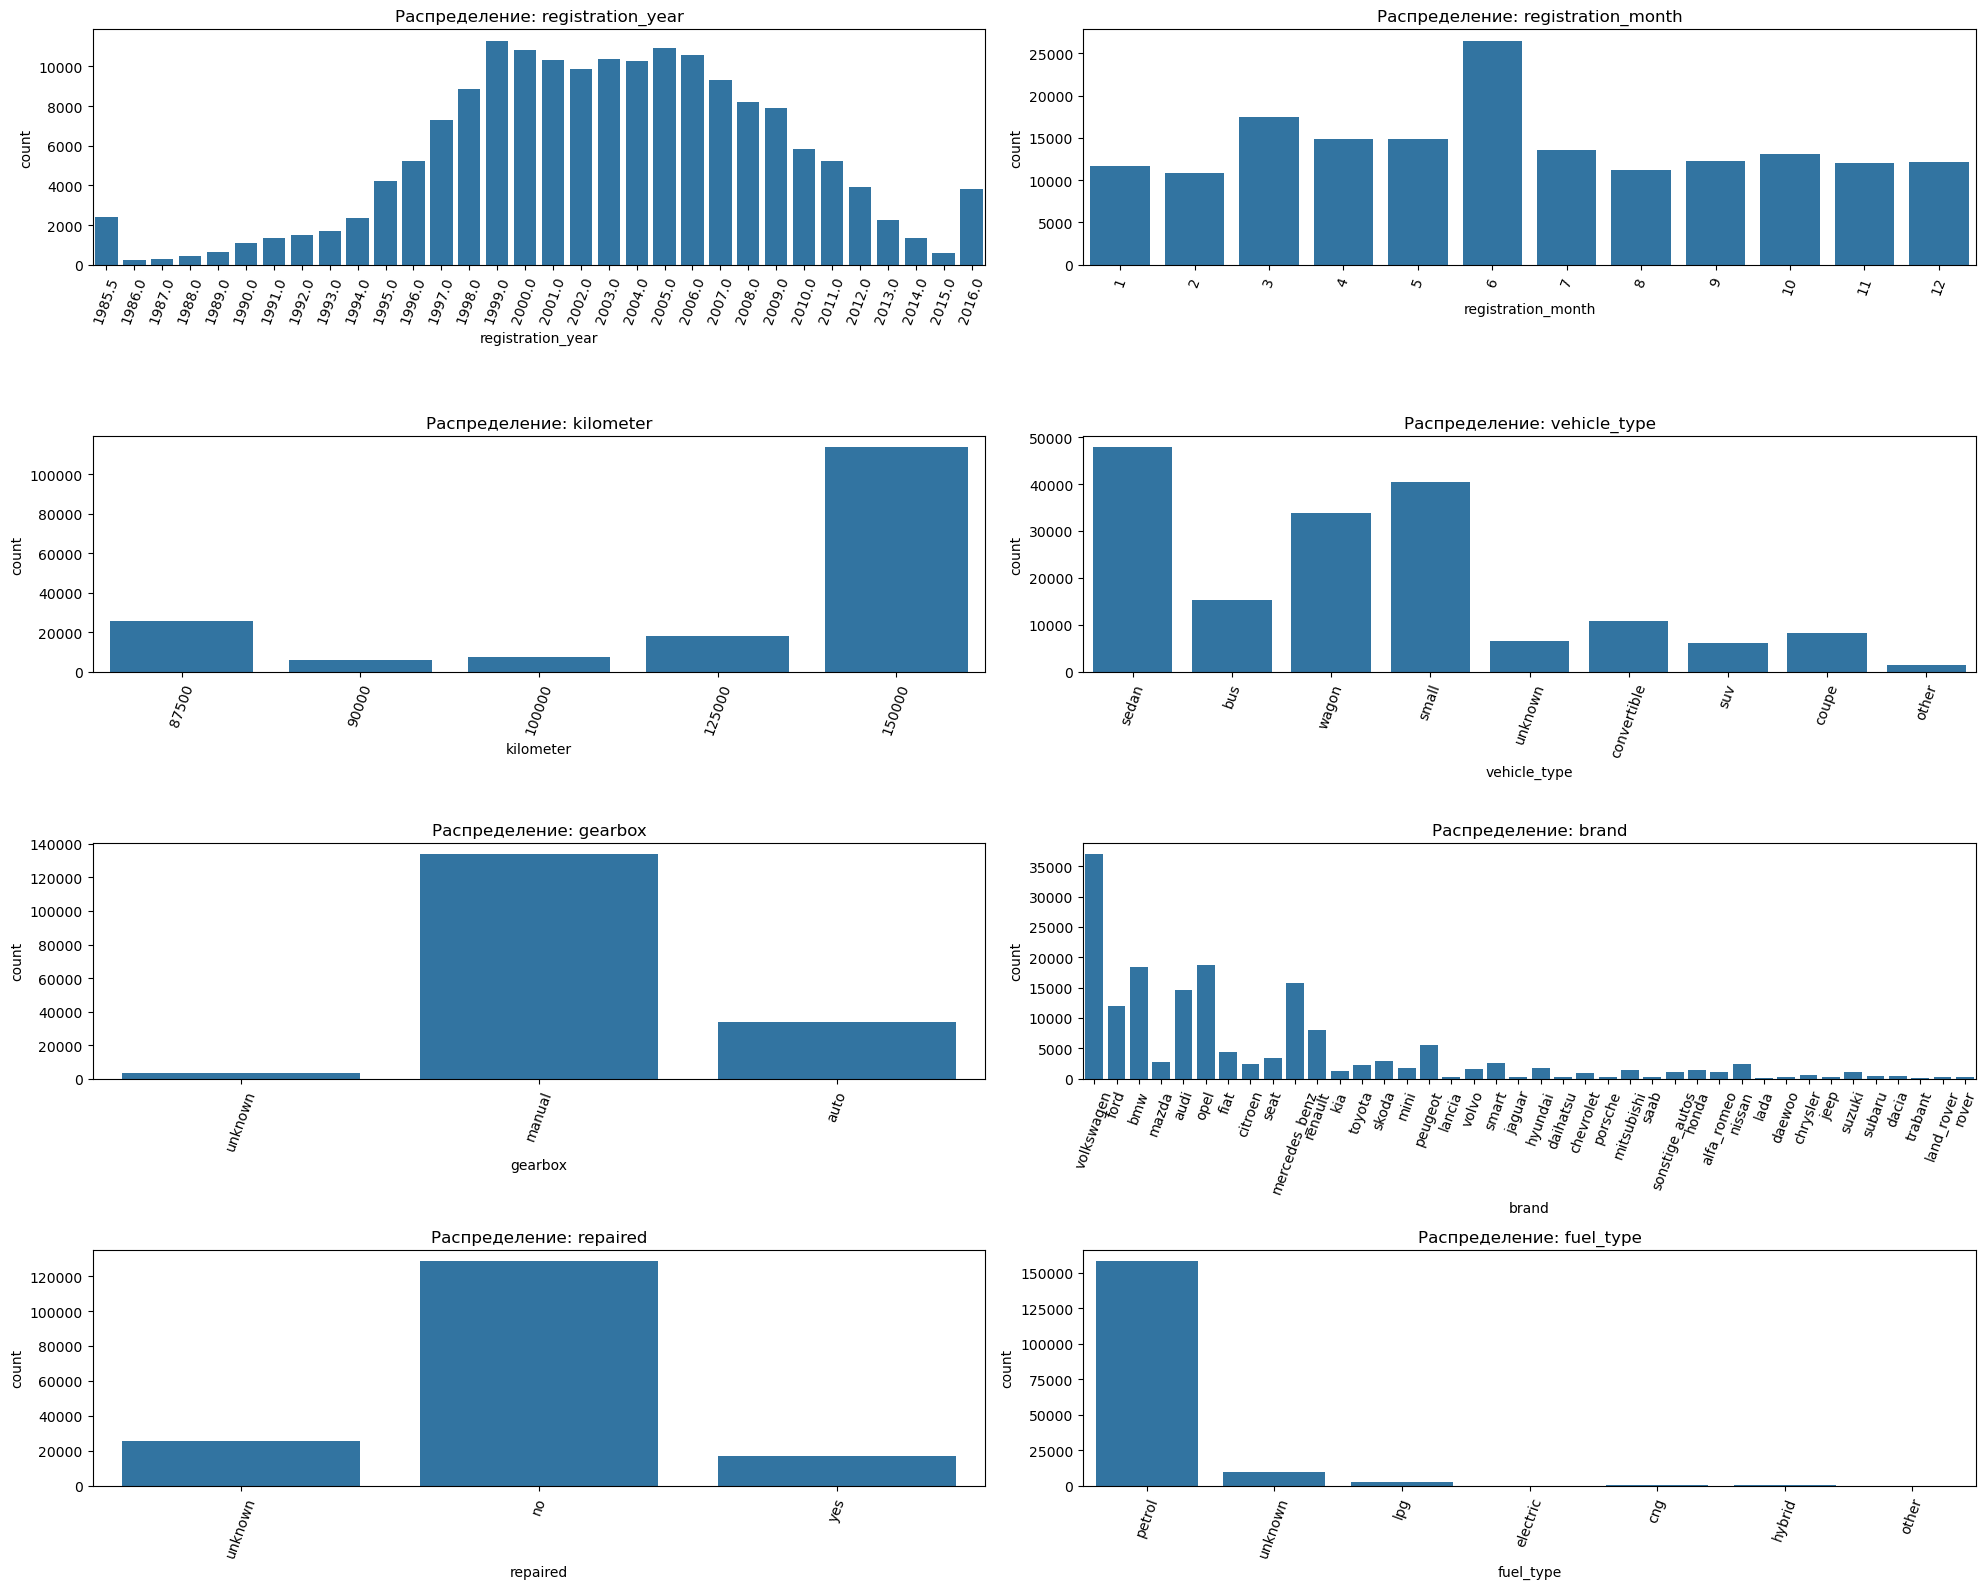

In [24]:
# Визуализация дискретных признаков
discrete_features = ['registration_year', 'registration_month', 'kilometer', 
                     'vehicle_type', 'gearbox', 'brand', 'repaired', 'fuel_type']

fig, axes = plt.subplots(4, 2, figsize=(20, 16))
axes = axes.flatten()

for idx, feature in enumerate(discrete_features):
    sns.countplot(data=train_df, x=feature, ax=axes[idx]) # , order=train_df[feature].value_counts().index
    axes[idx].set_title(f'Распределение: {feature}')
    axes[idx].tick_params(axis='x', rotation=70)
    
# axes[-1].axis('off')  # Скрыть последний пустой subplot
plt.tight_layout()
plt.show()


#### **3.6.1.1. Распределение категориальных признаков**

Категориальные признаки входят в состав дискретных признаков.

#### **3.6.1.2. Распределение дискретного высококардинального признака с 218k значений через countplot из seaborn.**

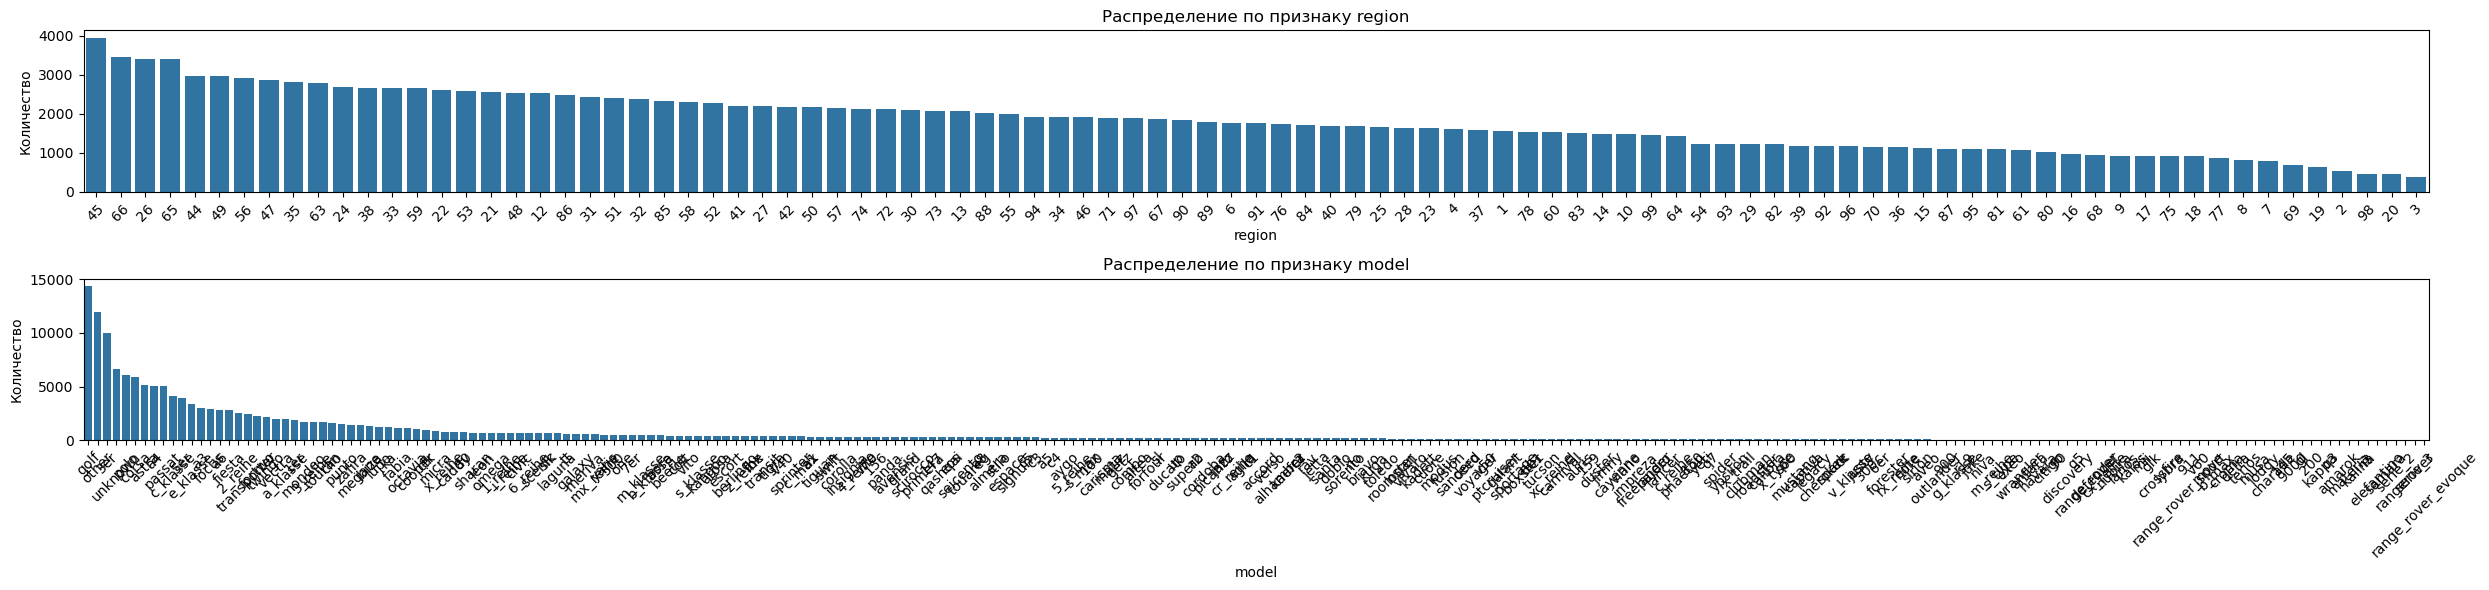

In [25]:
train_df['region'] = train_df['postal_code'] // 1000
test_df['region'] = test_df['postal_code'] // 1000
val_df['region'] = val_df['postal_code'] // 1000

features = ['region', 'model']

fig, axes = plt.subplots(2, 1, figsize=(25, 6))

for idx, feature in enumerate(features):
    sns.countplot(data=train_df, x=feature, ax=axes[idx], order=train_df[feature].value_counts().index)
    axes[idx].set_title(f'Распределение по признаку {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Количество')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **3.6.1.3. Облако слов для категориальных признаков**

Построим облако слов для категориальных признаков.

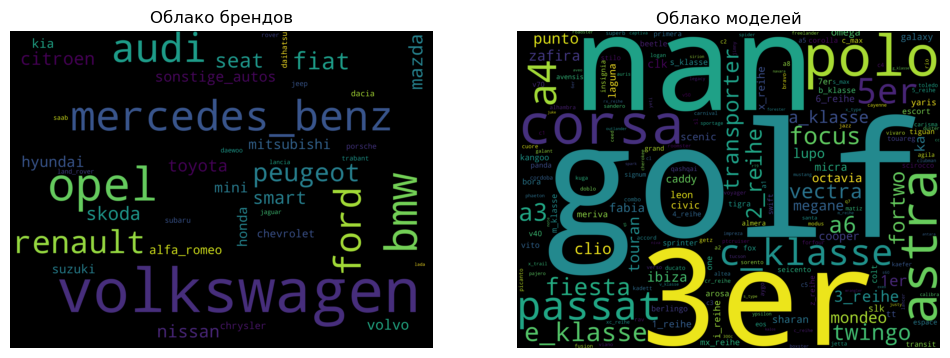

In [26]:
# Объединяем строки в единый текст для каждого столбца
brands_text = ' '.join(df['brand'].astype(str))
models_text = ' '.join(df['model'].astype(str))

# Создаем облако слов для брендов
wc_brands = WordCloud(width=4000, height=3000).generate(brands_text)

# Создаем облако слов для моделей автомобилей
wc_models = WordCloud(width=4000, height=3000).generate(models_text)

# Отображаем оба облака слов
plt.figure(figsize=(12, 6))

# Облако слов брендов
plt.subplot(1, 2, 1)
plt.imshow(wc_brands, interpolation='bilinear')
plt.title('Облако брендов')
plt.axis("off")

# Облако слов моделей
plt.subplot(1, 2, 2)
plt.imshow(wc_models, interpolation='bilinear')
plt.title('Облако моделей')
plt.axis("off")

plt.show()

### **3.6.2. Распределение непрерывных признаков**

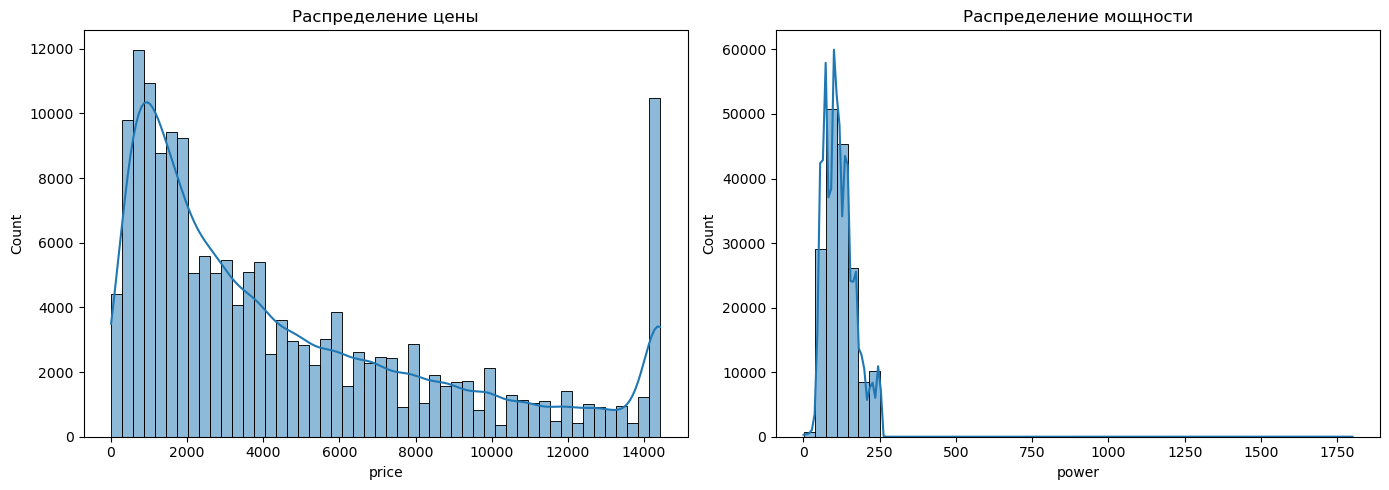

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(data=train_df, x='price', bins=50, kde=True, ax=axes[0])
axes[0].set_title('Распределение цены')

sns.histplot(data=train_df, x='power', bins=50, kde=True, ax=axes[1])
axes[1].set_title('Распределение мощности')

plt.tight_layout()
plt.show()


## **3.7. Расшифровка визуализации распределения признаков**

Несмотря на предобработку данных и удаление выбросов в частности, 

практически все признаки имеют скошенное распределение: Бренд, год регистрации, Тип топлива, тип авто, мощномть, пробег.

Нормальное распределение у года регистрации. 

Вопросы остались по мощности авто что считать выбросами, будет ли данная модель предсказывать стоимость спорткаров или нет? Выбросы по мощности свыше 1500 л.с. мы удалили.

К числовым признакам, имеющим скошенное распределение мы применим RobustScaler

К категориальным признакам мы применим категорирование OneHotEncoder

Месяц регистрации особой ценности признак не несет.


**Рекомендации для обучения модели:**

## **3.8. Оценка статистических предобработанных данных** 

In [28]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


**Price (Целевая переменная):**

- Средняя цена 3529€, медиана 2450€ → правосторонняя асимметрия (дорогие авто тянут среднее вверх)

- Диапазон 1-14400€ после очистки выбросов

- 0% авто стоят 1100-4999€ (IQR)

**RegistrationYear (Год регистрации):**

- Средний возраст: 2003 год (≈20 лет на момент 2023)

- 50% авто: 1999-2006 годы

- Узкое std=5.9 → однородная выборка по возрасту

**Power (Мощность):**

- Средняя 115 л.с., медиана 110 л.с. → симметричное распределение

- 50% авто: 75-143 л.с. (типичные легковые)

- Max 250 л.с. после очистки

**Kilometer (Пробег):**

⚠️ Подозрительно: 75% авто имеют ровно 150000 км

- Медиана = 75-й перцентиль = max = 150000 → скорее всего округление/ограничение данных

- Реальный разброс только в нижних 25% (90000-150000)

**RegistrationMonth:**

- Равномерное распределение (медиана=6, среднее=6.35)

- Слабое влияние на цену (сезонность регистрации)

**PostalCode:**

- Широкий разброс (1067-99998) → географический фактор

- Может влиять на цену через региональные различия

**Ключевые выводы:**

- `Kilometer` требует внимания - возможна цензура данных на 150000

- `Price` асимметричен - рассмотреть log-трансформацию

- `RegistrationYear` и `Power` - потенциально сильные предикторы (низкая вариативность, четкие границы)

**Рекомендации для обучения модели**

**1. Feature Engineering**

- Создать возраст авто (сильнее влияет, чем год)

In [29]:
train_df['age'] = 2016 - train_df['registration_year']
test_df['age'] = 2016 - test_df['registration_year']
val_df['age'] = 2016 - val_df['registration_year']


In [30]:
train_df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,region,age
222986,4499.000,sedan,2005.000,unknown,105,golf,150000,7,petrol,volkswagen,unknown,46149,46,11.000
337826,4700.000,bus,2003.000,manual,90,galaxy,150000,6,petrol,ford,no,53894,53,13.000
49641,649.000,wagon,1996.000,manual,64,golf,150000,5,petrol,volkswagen,no,27798,27,20.000
141350,999.000,wagon,1995.000,manual,150,3er,150000,5,petrol,bmw,no,89520,89,21.000
219405,3500.000,bus,2006.000,manual,143,5_reihe,150000,6,petrol,mazda,no,75447,75,10.000


## **3.9. Корреляция данных**

In [31]:
interval_cols = interval_cols = ['price', 'power', 'kilometer', 'postal_code', 'age'] # только дробные числа, или которые не в силах посчитать руками (если очень много значений, значит интервальный тип)

phik_corr = train_df.phik_matrix(interval_cols=interval_cols)
phik_corr     

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,postal_code,region,age
price,1.000,0.281,0.662,0.292,0.286,0.583,0.367,0.086,0.119,0.369,0.362,0.090,0.124,0.701
vehicle_type,0.281,1.000,0.616,0.383,0.235,0.900,0.202,0.128,0.261,0.593,0.329,0.064,0.120,0.403
registration_year,0.662,0.616,1.000,0.190,0.132,0.667,0.607,0.139,0.262,0.342,0.328,0.074,0.128,1.000
gearbox,0.292,0.383,0.190,1.000,0.549,0.626,0.019,0.141,0.142,0.521,0.273,0.086,0.170,0.135
power,0.286,0.235,0.132,0.549,1.000,0.520,0.051,0.033,0.057,0.372,0.082,0.042,0.063,0.094
model,0.583,0.900,0.667,0.626,0.520,1.000,0.472,0.140,0.368,0.998,0.272,0.207,0.293,0.648
kilometer,0.367,0.202,0.607,0.019,0.051,0.472,1.000,0.055,0.071,0.330,0.097,0.031,0.074,0.458
registration_month,0.086,0.128,0.139,0.141,0.033,0.140,0.055,1.000,0.113,0.073,0.252,0.027,0.064,0.093
fuel_type,0.119,0.261,0.262,0.142,0.057,0.368,0.071,0.113,1.000,0.224,0.180,0.046,0.085,0.152
brand,0.369,0.593,0.342,0.521,0.372,0.998,0.330,0.073,0.224,1.000,0.136,0.176,0.229,0.373


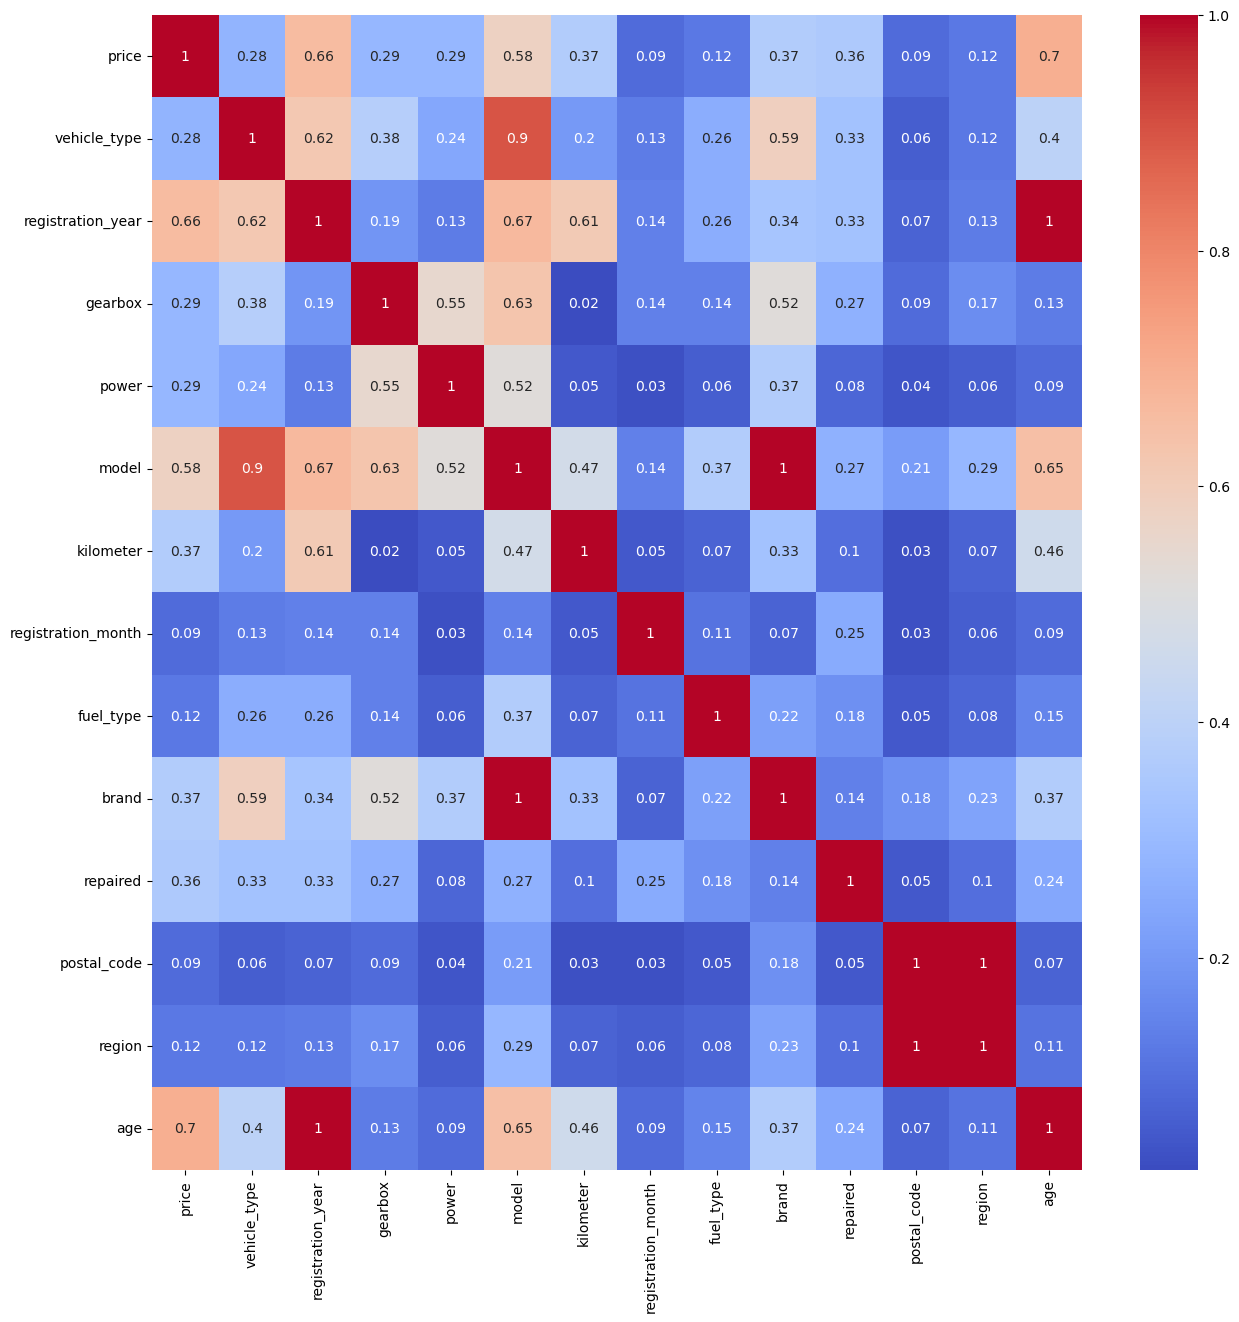

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

**Мультиколлинеарность наблюдается среди признаков:**

- `RegistrationYear` и `Age` (возраст = 2016 - год) - почти полная корреляция
- `Brand` и `Model` 
- `Kilometer` & `Kilometer_Max`

**Высокая корреляция с целевым признаком у:**

- `Age` - 0.67
- `RegistrationYear` - 0.63  (но модель lgbm с ним обучается хуже)
- `Model` - 0.58
- `Power` - 0.55

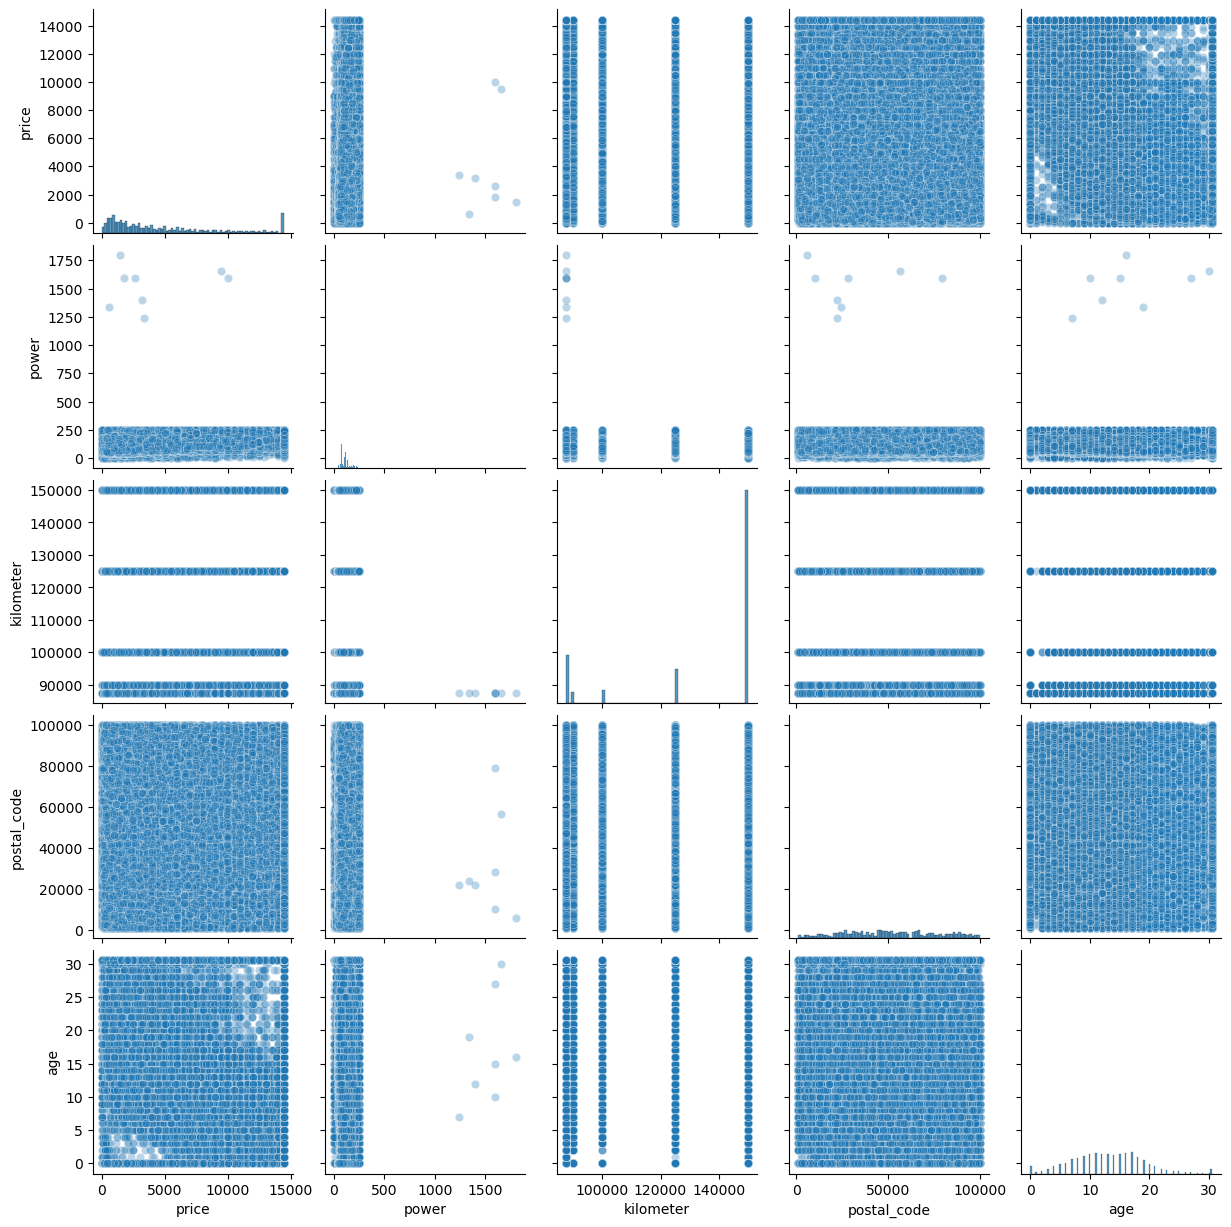

In [33]:
sns.pairplot(train_df[interval_cols], plot_kws={'alpha': 0.3})

## **3.10. Проверка данных на неоднородность: выявление нелинейных связей**

Мы надеемся, что выявление скрытых связей поможет повысить качество обучения.

**Мы применили:**

1. **Тесты Левена и Бартлетта** для проверки однородности дисперсий; 
2. **Simpson's Paradox:** когда общая корреляция и внутри груцппы имеют противопаоложные знаки;
3. Группировочный анализ;
4. Стабильность корреляций;
5. Скрытые кластеры;
6. Нелинейные связи;
7. Взаимодействия.

**Выводы:**
Скрытых взаимосвзей не обнаружено.  Казалось бы, что-то удалось найти, но при обучении модели они дают хуже результат, поэтому от этой информации пришлось отказаться при обучении модели. Блок удален за ненадобностью.

## **4. Feature Enginering**

## **4.1. Новые признаки на основе анализа неоднородности**

Создание кластера.

Благоджаря кластеризации, модель понимает контекст - одинаковые характеристики могут означать разную цену в зависимости от сегмента.

Кластеризация должна быть только на train, затем применяется к test через predict().

In [34]:
# Для кластеризации используем ВСЕ важные признаки
cluster_features = ['power', 'kilometer', 'age', 'price']  # можно добавить Region, но там много уникальных значений, может не сработать
X_cluster = train_df[cluster_features].fillna(train_df[cluster_features].median())

# Обучение
kmeans = KMeans(n_clusters=10, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_cluster)
X_test_cluster = test_df[cluster_features].fillna(train_df[cluster_features].median())
test_df['cluster'] = kmeans.predict(X_test_cluster)


Проведем ради интереса анлиз кластеров

In [35]:
# Анализ кластеров
cluster_analysis = train_df.groupby('cluster').agg({
                                    'price': ['mean', 'median', 'std', 'count'],
                                    'power': 'mean',
                                    'age': 'mean',
                                    'kilometer': 'mean',
                                    'brand': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'mixed'
}).round(0)

cluster_analysis.columns = ['Price_mean', 'Price_median', 'Price_std', 'Count', 'Power_avg', 'Age_avg', 'Km_avg', 'Top_Brand']
print(cluster_analysis.sort_values('Price_mean', ascending=False))

# Сравним разброс
print(f"Общий std цены: {train_df['price'].std():.0f}€")
print(f"Средний std внутри кластеров: {cluster_analysis['Price_std'].mean():.0f}€")

         Price_mean  Price_median  Price_std  Count  Power_avg  Age_avg     Km_avg   Top_Brand
cluster                                                                                       
8         14034.000     14422.000    655.000   7995    148.000    6.000  87820.000  volkswagen
4         11838.000     11800.000   2043.000  11640    186.000   10.000 150000.000         bmw
6         10818.000     10500.000   2698.000   5592    160.000    9.000 125000.000  volkswagen
5          9996.000      9900.000   1155.000   6214    118.000    7.000  87897.000  volkswagen
3          6163.000      5003.000   4440.000   7293    113.000   12.000 100000.000  volkswagen
1          6081.000      5999.000   1147.000   8634     94.000    9.000  87970.000  volkswagen
7          5626.000      5450.000   1450.000  27879    147.000   12.000 150000.000  volkswagen
2          2802.000      2500.000   1792.000  12673     92.000   14.000 125000.000  volkswagen
9          2091.000      2000.000   1206.000   867

Если средний std внутри кластеров < общего std - значит, кластеризация работает.

кластеризация РАБОТАЕТ!

Доказательства:

1. Разброс цен: 971€ → 6579€ (в 6.8 раз!)

- Кластер 5: 971€ (бюджет VW, 55 л.с., 22 года)

- Кластер 6: 6579€ (премиум Mercedes, 142 л.с., 18 лет)

2. Четкие сегменты:

Премиум (6000-6500€):
- Кластер 6: Mercedes (142 л.с., малый пробег)
- Кластер 4: BMW (199 л.с., мощные)

Средний (3800-5700€):
- Кластер 3,2,9: VW средней мощности

Бюджет (1700-2800€):
- Кластер 8,1,0: VW малой мощности, старые

Утиль (971€):
- Кластер 5: VW 55 л.с., 22 года

Кластеризация ОЧЕНЬ полезна - она разделила авто на 10 ценовых сегментов с разницей в 6.8 раз. Модель теперь понимает, что VW может стоить и 971€ (кластер 5), и 5739€ (кластер 3) в зависимости от характеристик.

**Однако, наличие признака `cluster` только ухудшает качесвто модели и мы не стали его включать в обучающую выборку.**

## **4.2. Стандартный Feature Engineering**

Всевозможные сложения и перемножения и деления  признаков качество модели lgbm не улучшили.

**Решили отказаться от всех производных признаков.**

# **5. Подготовка и обучение модели модели**

### **5.1. Отбор признаков с правильной корреляцией**

Удалим признаки с мультиколинеарностью и низкой корреляцией.

In [36]:
# 1. Отбор по корреляции с таргетом
target_corr = phik_corr['price'].abs()
selected = target_corr[(target_corr >= 0.01) & (target_corr <= 0.9)].index.tolist()

if 'price' in selected:
    selected.remove('price')

# 2. Сортируем по убыванию корреляции с таргетом (приоритет важным признакам)
selected_sorted = sorted(selected, key=lambda x: target_corr[x], reverse=True)

# 3. Удаляем мультиколлинеарность, сохраняя более важные
corr_matrix = phik_corr.loc[selected, selected]
to_drop = set()

for i, col1 in enumerate(selected_sorted):      # проходит по признакам, отсортированным по важности (корреляции с таргетом)
    if col1 in to_drop:                         # пропускает уже помеченные на удаление
        continue
    for col2 in selected_sorted[i+1:]:          # сравнивает каждый признак только с последующими (избегает дублирования) (индекс предыдущего +1)
        if col2 in to_drop:                     # пропускает уже помеченные на удаление
            continue
        if corr_matrix.loc[col1, col2] > 0.9:   # если корреляция между признаками > 0.9
            to_drop.add(col2)                   # # Удаляем col2 (у него корреляция с таргетом слабее)         

selected_features = [f for f in selected_sorted if f not in to_drop]

print(f"Отобрано: {len(selected_features)}")
print(f"Удалено: {len(to_drop)}")
print(f"\nТоп признаков по корреляции с таргетом:")
for f in selected_features:
    print(f"  {f:<20}: {target_corr[f]:.5f}")

# Классификация типов
feature_types = {
    'binary': [c for c in selected_features if train_df[c].nunique() == 2],
    'ordinal': [c for c in selected_features if 3 <= train_df[c].nunique() <= 5 and train_df[c].dtype in ['int64', 'float64'] and train_df[c].apply(lambda x: x == int(x) if pd.notna(x) and isinstance(x, (int, float)) else True).all()],
    'continuous': [c for c in selected_features if train_df[c].nunique() > 5],
    'nominal': [c for c in selected_features if train_df[c].dtype == 'object' or (train_df[c].dtype in ['int64', 'float64'] and train_df[c].nunique() <= 5)]

}

for ftype, cols in feature_types.items():
    print(f"{ftype.capitalize()}: {cols}")

Отобрано: 10
Удалено: 3

Топ признаков по корреляции с таргетом:
  age                 : 0.70089
  model               : 0.58337
  kilometer           : 0.36667
  repaired            : 0.36172
  gearbox             : 0.29195
  power               : 0.28611
  vehicle_type        : 0.28097
  region              : 0.12410
  fuel_type           : 0.11919
  registration_month  : 0.08557
Binary: []
Ordinal: ['kilometer']
Continuous: ['age', 'model', 'power', 'vehicle_type', 'region', 'fuel_type', 'registration_month']
Nominal: ['model', 'kilometer', 'repaired', 'gearbox', 'vehicle_type', 'fuel_type']


## **5.2. Классификация и стандартизация признаков**

In [37]:
#  классификация типов из отобранных признаков
def create_preprocessor():
    return ColumnTransformer([
        ('std', RobustScaler(), [
            'age', 
            'power', 
            'kilometer',
            # 'region' 
            
            ]), 
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), [
            'model', 
            'vehicle_type', 
            'gearbox', # с ним lr лучше, lgbm хуже, без него lgbm лучше
            'fuel_type', 
            'repaired', 
            'brand',
            # 'cluster'
            ])
    ], remainder='drop')


**Для обучения модели рассмотрим две модели:**

- **`Ridge`** - вместо более простого базового LinearRegression

**Преимущества `Ridge`:**

✅ Регуляризация — борется с переобучением

✅ Устойчивость к мультиколлинеарности — когда признаки коррелируют

✅ Стабильность — меньше чувствителен к выбросам

✅ Лучше обобщает — особенно при большом количестве признаков


- **`LightGBM`** - для примера градиентного бустинга.

✅ В 10-20 раз быстрее XGBoost

✅ Часто лучше CatBoost

✅ Использует меньше RAM

✅ Внутренний свой SelectKBest

✅ Работает с категориями БЕЗ One-Hot Encoding

## **5.3. Обучение модели**

In [38]:
# Подготовка данных
X_train = train_df.drop('price', axis=1)
y_train = train_df['price']

X_test = test_df.drop('price', axis=1)
y_test = test_df['price']

X_val = val_df.drop('price', axis=1)
y_val = val_df['price']

# 1. Ridge регрессия 
pipeline_ridge = Pipeline([
                            ('preprocessor', create_preprocessor()),
                            ('model', Ridge(alpha=10, random_state=42))  # alpha сам отбирает важные признаки через кэфициенты
])

param_grid_ridge = {
                    'model__alpha': [0.1, 1, 10, 100, 1000],  # Сила регуляризации
                    'model__fit_intercept': [True, False],
                    'model__solver': ['auto', 'svd', 'cholesky', 'lsqr']
}

grid_ridge_model = GridSearchCV(
                                pipeline_ridge, 
                                param_grid_ridge, 
                                cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='neg_root_mean_squared_error', 
                                n_jobs=-1
)

grid_ridge_model.fit(X_train, y_train)
y_pred_ridge = grid_ridge_model.predict(X_val) # X_test заменили на X_val для оценки на валидационной выборке, так как тестовая используется только для финальной проверки модели и не должна влиять на выбор гиперпараметров.


# Извлечение времени
best_idx = grid_ridge_model.best_index_
fit_time = grid_ridge_model.cv_results_['mean_fit_time'][best_idx]
predict_time = grid_ridge_model.cv_results_['mean_score_time'][best_idx]

rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))  # y_test заменили на y_val для оценки на валидационной выборке, так как тестовая используется только для финальной проверки модели и не должна влиять на выбор гиперпараметров.

print(f"Ridge | RMSE: {rmse_ridge:.2f} € | Fit: {fit_time:.2f}s | Predict: {predict_time:.2f}s | Refit: {grid_ridge_model.refit_time_:.2f}s | Best params: {grid_ridge_model.best_params_}")

# 2. LightGBM 
pipe_lgb = Pipeline([
                    ('preprocessor', create_preprocessor()),
                    ('feature_selection', SelectFromModel(lgb.LGBMRegressor(n_estimators=50), threshold='median')),
                    ('model', lgb.LGBMRegressor(random_state=42, verbose=-1)),

])

param_grid_lgb = {
                'model__n_estimators': [200, 220, 230, 240, 250],
                'model__max_depth': [10, 13],
                'model__learning_rate': [0.1, 0.11],
                'model__verbose': [-1],
            }


grid_lgbm_model = GridSearchCV(
                                pipe_lgb, 
                                param_grid_lgb, 
                                cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring='neg_root_mean_squared_error', 
                                n_jobs=-1,
                                refit=True
    )

grid_lgbm_model.fit(X_train, y_train)
y_pred_lgbm = grid_lgbm_model.predict(X_val)  # X_test заменили на X_val для оценки на валидационной выборке, так как тестовая используется только для финальной проверки модели 

# Извлечение времени
best_idx = grid_lgbm_model.best_index_
fit_time = grid_lgbm_model.cv_results_['mean_fit_time'][best_idx]
predict_time = grid_lgbm_model.cv_results_['mean_score_time'][best_idx]


rmse_lgbm = np.sqrt(mean_squared_error(y_val, y_pred_lgbm)) # y_test заменили на y_val для оценки на валидационной выборке, так как тестовая используется только для финальной проверки модели

print(f"LightGBM | RMSE: {rmse_lgbm:.2f} € | Fit: {fit_time:.2f}s | Predict: {predict_time:.2f}s | Refit: {grid_lgbm_model.refit_time_:.2f}s | Best params: {grid_lgbm_model.best_params_}")



Ridge | RMSE: 2225.34 € | Fit: 6.51s | Predict: 0.75s | Refit: 1.33s | Best params: {'model__alpha': 1, 'model__fit_intercept': True, 'model__solver': 'auto'}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 170593, number of used features: 286
[LightGBM] [Info] Start training from score 4654.407473
LightGBM | RMSE: 1466.24 € | Fit: 6.73s | Predict: 0.24s | Refit: 1.57s | Best params: {'model__learning_rate': 0.11, 'model__max_depth': 13, 'model__n_estimators': 250, 'model__verbose': -1}


Сохраним лучшую модель в переменную `best_model`

In [39]:
best_model = grid_lgbm_model.best_estimator_.named_steps['model'] if rmse_lgbm < rmse_ridge else grid_ridge_model.best_estimator_.named_steps['model']

## **5.4. Извлечение лучших признаков из модели**

Попробуем улучшить полученные результаты.

Извлечем наиболее влиятельные признаки и попробуем переобучить модель только на них, если результат окажется хуже - откажемся от переобучяенной модели.

Извлечем Feature Importance из лучшей модели чтобы сделать ее еще лучше.

In [40]:
# 2. Извлечение feature importance для лучшей модели (только для LightGBM, так как Ridge не предоставляет встроенный способ извлечения важности признаков, а его коэффициенты сложно интерпретировать из-за регуляризации)
feature_names = grid_lgbm_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nТоп-30 важных признаков:")
print(importance_df.head(30))




Топ-30 важных признаков:
                           feature  importance
0                         std__age        1818
1                       std__power        1644
2                   std__kilometer         437
252  cat__vehicle_type_convertible         144
168               cat__model_other         123
260            cat__gearbox_manual         107
269              cat__repaired_yes          94
225         cat__model_transporter          91
255        cat__vehicle_type_sedan          91
270                cat__brand_audi          87
257          cat__vehicle_type_suv          85
259        cat__vehicle_type_wagon          74
289       cat__brand_mercedes_benz          73
307          cat__brand_volkswagen          72
271                 cat__brand_bmw          67
258      cat__vehicle_type_unknown          62
256        cat__vehicle_type_small          60
253        cat__vehicle_type_coupe          57
268          cat__repaired_unknown          55
290                cat__brand_mini

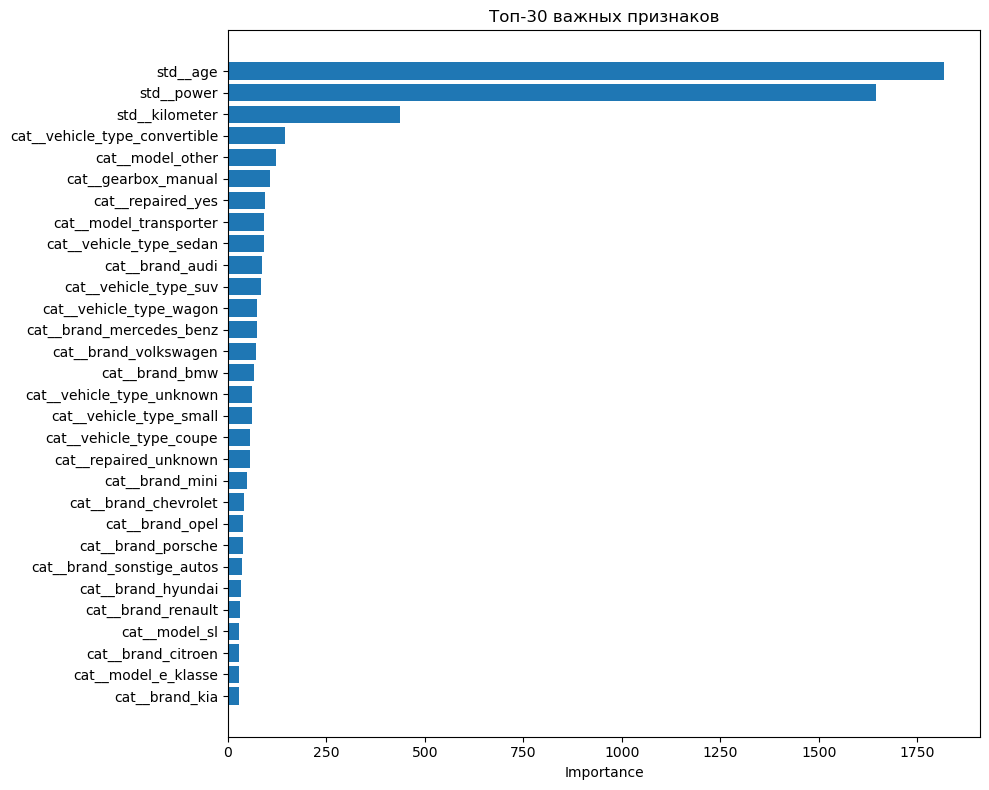

In [41]:
# Визуализация топ-30
plt.figure(figsize=(10, 8))
plt.barh(importance_df.head(30)['feature'], importance_df.head(30)['importance'])
plt.xlabel('Importance')
plt.title('Топ-30 важных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Три наиболее важных признака:
- возраст
- мощность 
- пробег

**Признаки с наименьшим влиянием на цену:**

- частные модели каких-то брендов 

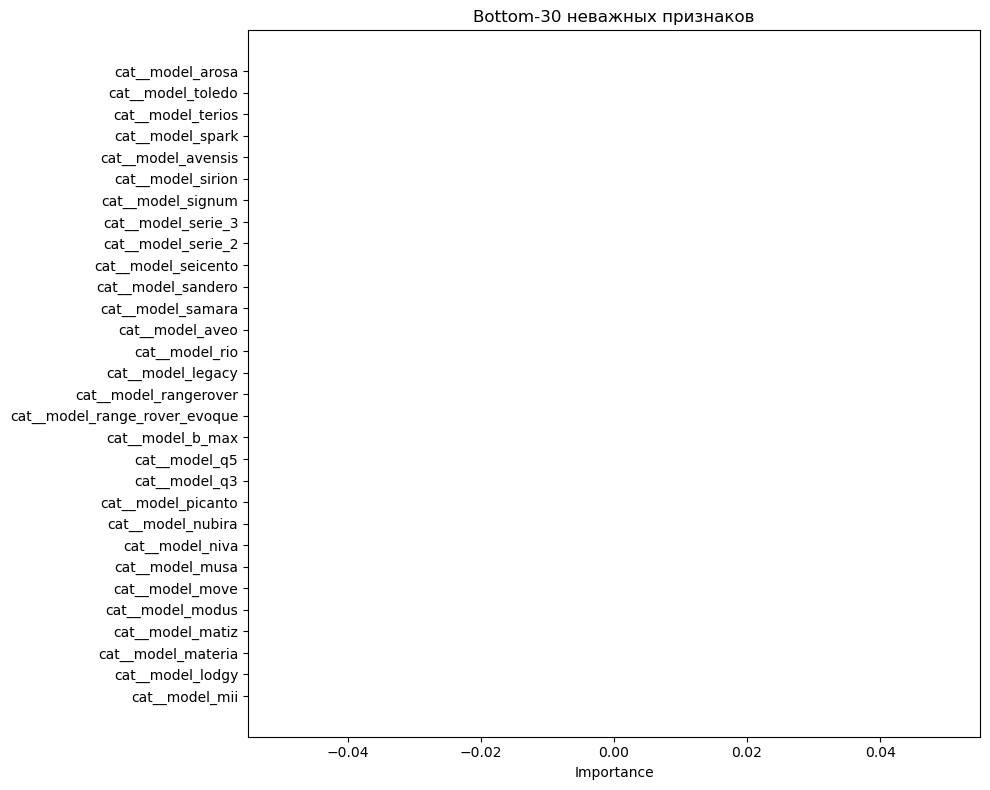

In [42]:
# Визуализация bottom-30
plt.figure(figsize=(10, 8))
plt.barh(importance_df.tail(30)['feature'], importance_df.tail(30)['importance'])
plt.xlabel('Importance')
plt.title('Bottom-30 неважных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
# 3. Выбор топ-N признаков (например, топ-30)
top_n = 30
top_features = importance_df.head(top_n)['feature'].tolist()
top_indices = [list(feature_names).index(f) for f in top_features]

print(f"\nОтобрано {top_n} признаков")

# 4. Трансформация данных с отбором признаков
X_train_transformed = grid_lgbm_model.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_transformed = grid_lgbm_model.best_estimator_.named_steps['preprocessor'].transform(X_test)

X_train_selected = X_train_transformed[:, top_indices]
X_test_selected = X_test_transformed[:, top_indices]

# 5. Переобучение модели на отобранных признаках
# Получить лучшую модель
best_model = grid_lgbm_model.best_estimator_.named_steps['model']

# Создать копию с теми же параметрами
model_refit_temp = lgb.LGBMRegressor(**best_model.get_params())
model_refit_temp.fit(X_train_selected, y_train)
y_pred_selected = model_refit_temp.predict(X_test_selected)

rmse_selected = np.sqrt(mean_squared_error(y_test, y_pred_selected))

print(f"\nМодель с {top_n} признаками RMSE: {rmse_selected:.2f}")
print(f"Разница: {rmse_selected - rmse_lgbm:+.2f}")



Отобрано 30 признаков

Модель с 30 признаками RMSE: 1513.97
Разница: +47.72


Модель с отобранным топом признаков оказалась хуже, поэтому не будем отбирать топ признаков.

## **5.5. Дообучение модели на извлеченных признаках**

RMSE Показывает среднюю ошибку в евро

In [44]:
# Проверим среднюю цену
print(f"Средняя цена: {y_train.mean():.2f}€")
print(f"RMSE LightGBM: {rmse_lgbm:.2f}€ ({rmse_lgbm/y_train.mean()*100:.1f}% от средней)")

Средняя цена: 4654.41€
RMSE LightGBM: 1466.24€ (31.5% от средней)


In [46]:
from sklearn.dummy import DummyRegressor

# Предсказания
y_pred_train = grid_lgbm_model.predict(X_train)
y_pred_val = grid_lgbm_model.predict(X_val)
y_pred_test = grid_lgbm_model.predict(X_test)

# RMSE
rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)))
rmse_val = round(np.sqrt(mean_squared_error(y_val, y_pred_val)))
rmse_test =  round(np.sqrt(mean_squared_error(y_test, y_pred_test)))

# Dummy
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_selected, y_train)
rmse_dummy = round(np.sqrt(mean_squared_error(y_test, dummy.predict(X_test_selected))))

# Таблица
results = pd.DataFrame({
    'Выборка': ['Train', 'Valid', 'Test', 'Разница Train=>Test', 'Разница Train=>Test (%)'],
    'LGBM': [rmse_train, rmse_val, rmse_test, f'{rmse_test - rmse_train:+.2f}€', f'{(rmse_test - rmse_train) / rmse_train * 100:+.2f}%'],
    'Dummy': [rmse_dummy, rmse_dummy, rmse_dummy, 0, 0],

})

# Транспонируем таблицу
transposed_results = results.T

# Названия строк становятся названиями столбцов
new_header = transposed_results.iloc[0]
transposed_results.columns = new_header
transposed_results.drop('Выборка', axis=0, inplace=True)

# Вывод результата округленного до двух знаков после запятой
print(transposed_results.round(2))

Выборка Train Valid  Test Разница Train=>Test Разница Train=>Test (%)
LGBM     1429  1466  1482             +53.00€                  +3.71%
Dummy    4261  4261  4261                   0                       0


# **6 Выводы**

## **6.1 Основные выводы**

**Метрика качества:**

- Цель была снизить RMSE до уровня менее 2500 евро. Модель достигла показателя примерно 1481 евро на тестовом наборе, что значительно лучше заданного порога.

**Обобщающая способность:**

- Модель показывает небольшую деградацию производительности на валидационной выборке (+2.5%) и на тестовых данных (+3.69%), что свидетельствует о хорошей способности обобщения. Небольшое увеличение ошибки является нормальным и ожидаемым поведением, особенно учитывая масштаб изменения (менее 4%).

**Качество обучения:**

- Модель обучена хорошшо, оптимальным образом. Показатель ошибки на тренировочном наборе отличается незначительно от ошибок на валидирующем и тестовом наборах. Это подтверждает отсутствие признаков серьезного переобучения. Переобучение проявлялось бы значительным увеличением ошибки на новых данных относительно тренировки.

- Значение ошибки RMSE модели LGBM почти втрое меньше ошибки базового регрессора ("Dummy"), что демонстрирует эффективность подобранной модели.

## **6.2. Общее заключение**

В рамках проекта была разработана модель для определения рыночной стоимости автомобилей с пробегом для сервиса «Не бит, не крашен». 

Перед нами стояла задача обучить две модели с метриками не более 2500 € по RMSE. 

Работа выполнена в соответствии с требованиями заказчика по качеству предсказания, скорости работы и времени обучения. Поставленная задача успешно выполнена.


### **6.2.1. Выполненные этапы:**

1. Подготовка данных:

- Загрузка датасета из 354 тыс. записей с 15 признаками

- Разделение на 

    -- 60%: обучающую ( 212 620 строк);

    -- 15%: валидационную (53 156) выборку.

    -- 25%: тестовую (88 593 строк); 

 

- Создание и предварительная обработка в автоматизированном пайплайне из 7 последовательных шагов:

- Коррекция ошибок (замена некорректного значения 0 в `RegistrationMonth` на медиану 6; замена `gasoline` на `petrol`);

- Удаление неинформативных столбцов (`DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`);

- Проверка и Нормализация дробных чисел;

- Оценка выбросов методом IQR, обработка выбросов методом винзоризации с удалением экстремальных значений (определены и оставлены только нормальные значения для `Power`: 1-1900 л.с., `RegistrationYear`: 1920-2016, `Price` > 1€);

- Обработка пропущенных значений (подстановка `Unknown`);

- Удаление явных дубликатов;

- Проверка на наличие неявных дубликатов и проверка уникальных значений.

Качественная предобработка данных принесла наибольший эффект для качественного обучения модели.

Предобработка проводилась избирательно: все методы применялись к тренировочной выборке и только половина из них к тестовой и валидационной выборке. Выбросы удалялись в тестовой выборке только по цене, так как на проде целевая перемення на вход не приходит, ее надо предсказывать. 

### **6.2.2. Глубокий анализ данных (EDA)**

Ключевой особенностью проекта стал не просто механический подход к обучению моделей, а комплексный исследовательский анализ.

- **Корреляционный анализ:** выявлены наиьболее влиятельные признаки, влияющие на цену автомобиля, устраненеа мультиколлинеарность с коэффициентом более 0.9. Все признаки с коэффициентом  менее 0.9 оказались важны, исключили дополнительно признак `PostalCode`.

- **Поиск скрытых паттернов и взаимосвязей:**

- Анализ однородности дисперсий: проведены тесты Левена, Бартлетта и Флигнера для обнаружения подозрительных паттернов и неоднородности данных

- Проверка парадокса Симпсона: исключена возможность обманчивых корреляций из-за скрытых группировок

- Комплексный анализ неоднородности:

- Тесты однородности дисперсий

- Анализ группировок по категориальным признакам

- Проверка стабильности корреляций

- Поиск скрытых кластеров

- Анализ нелинейных связей

Поиск скрытых взаимосвязей ожидаемой пользы для качества обучения модели не принес, но мы предприняли попытку обнаружить нелинейные скрытые взаимосвязи - таковых необнаружено.

### **6.2.3. Feature Engineering**

- Создали новые признаки: Возраст авто `'age'` вместо пробега `'Kilometer'` (лучше коррелирует), `'region'` на основе `'postal_code'`.

- Отбор признаков с удалением мультиколлинеарных переменных

- Классификация признаков по типу (числовые/категориальные)

- Определение оптимального набора признаков для обучения

- Попытки создания новых признаков путем сложения, перемножения и кластеризации, но  значительного улучшения не принесли)

- Кластеризация данных и создания нового признака на основе кластеризации (ожидаемого эффекта кластеризация не принесла, да и модель LGBM сама внутри это делает)

- При обучении в пайплайн зашщили `SelectFromModel`, которая была призвана отобрать лучшие признаки

### **6.2.4. Обучение и выбор моделей**

Протестированы две модели с использованием разработанного пайплайна:

**1) Лучшей моделью мы определили LightGBM** на тесте

**Модель: LightGBM** ⭐

**RMSE:** 1481 €

**Время обучения:** 6 сек

**Лучшие параметры:** learning_rate=0.11, max_depth=13, n_estimators=250

Проведена гиперпараметрическая оптимизация с использованием GridSearchCV и кросс-валидацией.

**2) Вторая модель Ridge Regression** показала худшие результаты на валидационной выборке:

**RMSE:** 2270 €

**Время обучения:** 6 сек

**Лучшие параметры**: fit_intercept=True, positive=False

✅ Хотя обе модели выполнили требование RMSE < 2500 €

✅ LightGBM показала лучшие результаты по всем критериям:

- На 34% точнее Linear Regression (1466 vs 2225 €)

- На 0.22 сек быстрее в обучении (6.12 vs 6.35 сек)

Оптимальный баланс качества и скорости

### **6.2.5. Оптимизация обученных моделей**

Предприняли попытку извлечения лучших признков, но это оказалось ни к чему, так как модель уже достигла максимальных результатов, поэтому переобучать модель не стали.

### **6.2.6. Ключевые факторы успеха**


**Таких высоких показателей удалось добиться благодаря:**

- В первую очереь, качественной предобработке данных поспособствовало: прежде всего, тщательная обработка выбросов, включая целевой признак, и пропущенных значений, замена ошибочных значений, ограничением максимальных и минимальных значений;

- Подбор наиболее удачных вариантов обработки выбросов и пропусков;

- Подбор гиперпараметров;

- Глубокий EDA: выявление скрытых паттернов, анализ неоднородности, проверка статистических гипотез;

- Систематический подход: создание воспроизводимого пайплайна с автоматической обработкой данных;

- Комплексный анализ: не ограничились базовыми методами, провели многоуровневое исследование структуры данных.

- Обучение нескольких моделей, выбирая лучшую;

**Практическая ценность:**

Разработанное решение обеспечивает:

- Автоматическую обработку новых данных через пайплайн

- Воспроизводимость результатов

- Масштабируемость для больших объемов данных

- Готовность к продакшену: модель готова к интеграции в приложение сервиса

- Модель LightGBM рекомендуется к внедрению для быстрой и точной оценки рыночной стоимости автомобилей в приложении «Не бит, не крашен».